In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [2]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
sys.path.append('../')

In [5]:
import phononet as pn
import utils

In [6]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 1794.43it/s]


In [7]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [8]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

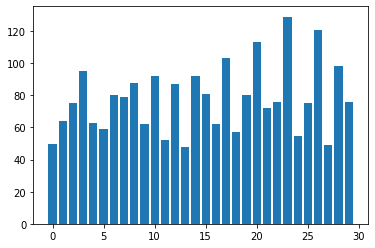

In [9]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [10]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

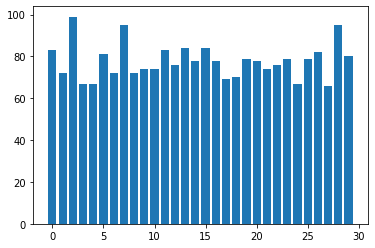

In [11]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [12]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [13]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [14]:
from tensorflow.keras.layers import Conv2D
from utils import MySequential, ConfusionMatrixMetric, PeriodicPaddingConv2D

In [15]:
ConvLayer=Conv2D

In [16]:
class ConvBlock(keras.layers.Layer):
    
    def __init__(self,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.max_pool=kwargs.pop('max_pool',None)
        self.dropout=kwargs.pop('dropout',None)
        self.zero_padding=kwargs.pop('zero_padding',None)
        self.args=args
        self.kwargs=kwargs
        
        
    def build(self,input_shape):
        layers=[tf.keras.layers.Input(shape=input_shape[1:])]
        if self.zero_padding is not None:
            layers.append(tf.keras.layers.ZeroPadding2D(padding=self.zero_padding))
        layers.extend([
            ConvLayer(*self.args,**self.kwargs),
            keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
            keras.layers.BatchNormalization(axis=[3]), # batch normalization on everything but last dimension
        ])
        if self.max_pool is not None:
            layers.append(keras.layers.MaxPool2D(self.max_pool))
        if self.dropout is not None:
            layers.append(keras.layers.Dropout(self.dropout))
        self.model=keras.Sequential(layers)
        
    def call(self,x):
        return self.model(x)

In [17]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    ConvBlock(64,(3,3),
              name='conv_block_1',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(128,(3,3),
              name='conv_block_2',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,3),
              dropout=dropout_prob,
             ),
    ConvBlock(150,(3,3),
              name='conv_block_3',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(200,(3,3),
              name='conv_block_4',
              padding='same',
              kernel_initializer=kernel_initializer,
             ),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 10, 750, 64)       896       
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 8, 250, 128)       74368     
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 6, 125, 150)       173550    
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 6, 125, 200)       271000    
_________________________________________________________________
gba (GlobalAveragePooling2D) (None, 200)             

In [18]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [19]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
72/72 [==============================] - 11s 157ms/step - loss: 3.4037 - accuracy: 0.0612 - F1_0: 0.0756 - F1_1: 0.0268 - F1_2: 0.0000e+00 - F1_3: 0.0816 - F1_4: 0.0134 - F1_5: 0.0309 - F1_6: 0.0311 - F1_7: 0.0428 - F1_8: 0.0549 - F1_9: 0.0285 - F1_10: 0.0000e+00 - F1_11: 0.1296 - F1_12: 0.0407 - F1_13: 0.0000e+00 - F1_14: 0.1256 - F1_15: 0.0864 - F1_16: 0.0013 - F1_17: 0.0380 - F1_18: 0.0530 - F1_19: 0.0059 - F1_20: 0.1886 - F1_21: 0.0253 - F1_22: 0.0091 - F1_23: 0.0127 - F1_24: 0.0307 - F1_25: 0.0406 - F1_26: 0.0338 - F1_27: 0.0000e+00 - F1_28: 0.0590 - F1_29: 0.0165 - val_loss: 4.2480 - val_accuracy: 0.0360 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0403 - val_F1_15: 0.0000e+00 

72/72 [==============================] - 11s 146ms/step - loss: 2.1878 - accuracy: 0.3863 - F1_0: 0.2833 - F1_1: 0.1215 - F1_2: 0.3648 - F1_3: 0.3676 - F1_4: 0.4611 - F1_5: 0.4101 - F1_6: 0.3009 - F1_7: 0.4797 - F1_8: 0.4529 - F1_9: 0.3483 - F1_10: 0.4374 - F1_11: 0.4055 - F1_12: 0.3350 - F1_13: 0.3783 - F1_14: 0.4786 - F1_15: 0.4625 - F1_16: 0.2979 - F1_17: 0.1211 - F1_18: 0.5963 - F1_19: 0.4477 - F1_20: 0.4565 - F1_21: 0.3565 - F1_22: 0.2202 - F1_23: 0.0408 - F1_24: 0.3443 - F1_25: 0.3015 - F1_26: 0.4533 - F1_27: 0.1908 - F1_28: 0.3931 - F1_29: 0.0764 - val_loss: 3.3298 - val_accuracy: 0.1452 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0606 - val_F1_3: 0.0000e+00 - val_F1_4: 0.1053 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0909 - val_F1_7: 0.0606 - val_F1_8: 0.0857 - val_F1_9: 0.2418 - val_F1_10: 0.4737 - val_F1_11: 0.0000e+00 - val_F1_12: 0.2000 - val_F1_13: 0.2778 - val_F1_14: 0.1408 - val_F1_15: 0.1818 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - val_F1_18: 0.0364 

Epoch 14/100
72/72 [==============================] - 11s 147ms/step - loss: 1.2932 - accuracy: 0.6597 - F1_0: 0.6914 - F1_1: 0.4755 - F1_2: 0.5651 - F1_3: 0.6464 - F1_4: 0.7368 - F1_5: 0.7260 - F1_6: 0.6662 - F1_7: 0.6523 - F1_8: 0.7967 - F1_9: 0.7229 - F1_10: 0.6710 - F1_11: 0.5291 - F1_12: 0.6402 - F1_13: 0.6701 - F1_14: 0.7381 - F1_15: 0.7748 - F1_16: 0.7407 - F1_17: 0.4215 - F1_18: 0.7631 - F1_19: 0.7911 - F1_20: 0.6216 - F1_21: 0.6431 - F1_22: 0.6969 - F1_23: 0.5691 - F1_24: 0.5909 - F1_25: 0.5390 - F1_26: 0.5910 - F1_27: 0.5697 - F1_28: 0.5626 - F1_29: 0.6238 - val_loss: 2.9033 - val_accuracy: 0.3102 - val_F1_0: 0.2000 - val_F1_1: 0.0741 - val_F1_2: 0.0448 - val_F1_3: 0.0000e+00 - val_F1_4: 0.5000 - val_F1_5: 0.4348 - val_F1_6: 0.0000e+00 - val_F1_7: 0.4583 - val_F1_8: 0.1935 - val_F1_9: 0.1250 - val_F1_10: 0.6667 - val_F1_11: 0.1935 - val_F1_12: 0.6032 - val_F1_13: 0.3146 - val_F1_14: 0.1569 - val_F1_15: 0.3333 - val_F1_16: 0.0000e+00 - val_F1_17: 0.1026 - val_F1_18: 0.1250 - v

Epoch 21/100
72/72 [==============================] - 11s 146ms/step - loss: 0.7450 - accuracy: 0.8043 - F1_0: 0.7721 - F1_1: 0.7233 - F1_2: 0.8176 - F1_3: 0.7183 - F1_4: 0.8340 - F1_5: 0.8437 - F1_6: 0.5736 - F1_7: 0.8044 - F1_8: 0.9048 - F1_9: 0.7191 - F1_10: 0.8374 - F1_11: 0.8286 - F1_12: 0.8571 - F1_13: 0.8492 - F1_14: 0.8209 - F1_15: 0.8136 - F1_16: 0.8739 - F1_17: 0.6474 - F1_18: 0.8861 - F1_19: 0.8631 - F1_20: 0.8222 - F1_21: 0.8091 - F1_22: 0.8100 - F1_23: 0.6809 - F1_24: 0.8184 - F1_25: 0.8034 - F1_26: 0.8049 - F1_27: 0.6986 - F1_28: 0.7513 - F1_29: 0.6136 - val_loss: 2.6698 - val_accuracy: 0.3586 - val_F1_0: 0.2817 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.5714 - val_F1_5: 0.4000 - val_F1_6: 0.4000 - val_F1_7: 0.5294 - val_F1_8: 0.2727 - val_F1_9: 0.6087 - val_F1_10: 0.7500 - val_F1_11: 0.1538 - val_F1_12: 0.0667 - val_F1_13: 0.4167 - val_F1_14: 0.0500 - val_F1_15: 0.5000 - val_F1_16: 0.1538 - val_F1_17: 0.2174 - val_F1_18: 0.3103 - v

Epoch 28/100
72/72 [==============================] - 11s 146ms/step - loss: 0.5577 - accuracy: 0.8563 - F1_0: 0.8629 - F1_1: 0.7950 - F1_2: 0.8534 - F1_3: 0.8056 - F1_4: 0.8705 - F1_5: 0.8167 - F1_6: 0.8398 - F1_7: 0.8701 - F1_8: 0.8683 - F1_9: 0.8768 - F1_10: 0.8156 - F1_11: 0.7463 - F1_12: 0.9244 - F1_13: 0.8998 - F1_14: 0.8285 - F1_15: 0.9450 - F1_16: 0.9100 - F1_17: 0.7209 - F1_18: 0.8760 - F1_19: 0.8953 - F1_20: 0.8786 - F1_21: 0.7831 - F1_22: 0.8457 - F1_23: 0.8332 - F1_24: 0.8586 - F1_25: 0.8148 - F1_26: 0.7939 - F1_27: 0.8232 - F1_28: 0.8423 - F1_29: 0.7599 - val_loss: 2.1275 - val_accuracy: 0.4529 - val_F1_0: 0.3939 - val_F1_1: 0.2308 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2381 - val_F1_4: 0.6667 - val_F1_5: 0.5455 - val_F1_6: 0.5000 - val_F1_7: 0.4516 - val_F1_8: 0.3429 - val_F1_9: 0.2800 - val_F1_10: 0.7368 - val_F1_11: 0.1509 - val_F1_12: 0.5714 - val_F1_13: 0.4839 - val_F1_14: 0.2857 - val_F1_15: 0.2222 - val_F1_16: 0.0000e+00 - val_F1_17: 0.4348 - val_F1_18: 0.3590 - val_F

Epoch 35/100
72/72 [==============================] - 11s 146ms/step - loss: 0.3756 - accuracy: 0.9049 - F1_0: 0.9343 - F1_1: 0.8363 - F1_2: 0.8604 - F1_3: 0.9286 - F1_4: 0.9380 - F1_5: 0.9634 - F1_6: 0.9381 - F1_7: 0.8881 - F1_8: 0.9255 - F1_9: 0.8441 - F1_10: 0.9205 - F1_11: 0.8685 - F1_12: 0.8990 - F1_13: 0.9041 - F1_14: 0.9029 - F1_15: 0.9192 - F1_16: 0.8543 - F1_17: 0.9323 - F1_18: 0.9096 - F1_19: 0.9663 - F1_20: 0.9027 - F1_21: 0.8658 - F1_22: 0.9165 - F1_23: 0.8640 - F1_24: 0.9698 - F1_25: 0.9066 - F1_26: 0.8700 - F1_27: 0.8674 - F1_28: 0.8173 - F1_29: 0.8442 - val_loss: 1.8596 - val_accuracy: 0.5025 - val_F1_0: 0.4144 - val_F1_1: 0.3750 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1463 - val_F1_4: 0.5238 - val_F1_5: 0.7556 - val_F1_6: 0.6400 - val_F1_7: 0.4444 - val_F1_8: 0.2857 - val_F1_9: 0.6479 - val_F1_10: 0.6800 - val_F1_11: 0.5882 - val_F1_12: 0.7500 - val_F1_13: 0.4490 - val_F1_14: 0.2188 - val_F1_15: 0.6000 - val_F1_16: 0.0000e+00 - val_F1_17: 0.3438 - val_F1_18: 0.3810 - val_F

Epoch 42/100
72/72 [==============================] - 10s 146ms/step - loss: 0.3278 - accuracy: 0.9184 - F1_0: 0.9296 - F1_1: 0.8832 - F1_2: 0.9300 - F1_3: 0.9166 - F1_4: 0.9138 - F1_5: 0.9020 - F1_6: 0.9193 - F1_7: 0.9709 - F1_8: 0.9290 - F1_9: 0.9195 - F1_10: 0.8859 - F1_11: 0.9553 - F1_12: 0.9378 - F1_13: 0.9680 - F1_14: 0.8725 - F1_15: 0.9355 - F1_16: 0.9497 - F1_17: 0.9224 - F1_18: 0.8827 - F1_19: 0.9232 - F1_20: 0.9687 - F1_21: 0.9228 - F1_22: 0.9462 - F1_23: 0.9007 - F1_24: 0.8215 - F1_25: 0.8705 - F1_26: 0.8466 - F1_27: 0.9102 - F1_28: 0.9092 - F1_29: 0.9084 - val_loss: 2.3378 - val_accuracy: 0.4901 - val_F1_0: 0.5060 - val_F1_1: 0.2667 - val_F1_2: 0.0482 - val_F1_3: 0.2791 - val_F1_4: 0.7925 - val_F1_5: 0.6875 - val_F1_6: 0.5714 - val_F1_7: 0.3467 - val_F1_8: 0.2000 - val_F1_9: 0.3922 - val_F1_10: 0.7843 - val_F1_11: 0.2182 - val_F1_12: 0.8077 - val_F1_13: 0.4727 - val_F1_14: 0.1951 - val_F1_15: 0.2000 - val_F1_16: 0.0000e+00 - val_F1_17: 0.5172 - val_F1_18: 0.7805 - val_F1_19

Epoch 49/100
72/72 [==============================] - 11s 146ms/step - loss: 0.2823 - accuracy: 0.9319 - F1_0: 0.9075 - F1_1: 0.8913 - F1_2: 0.8830 - F1_3: 0.8822 - F1_4: 0.8433 - F1_5: 0.9788 - F1_6: 0.9532 - F1_7: 0.9638 - F1_8: 0.9160 - F1_9: 0.9045 - F1_10: 0.9807 - F1_11: 0.8736 - F1_12: 0.9666 - F1_13: 0.9790 - F1_14: 0.8998 - F1_15: 0.9871 - F1_16: 0.9080 - F1_17: 0.9435 - F1_18: 0.8561 - F1_19: 0.9343 - F1_20: 0.8979 - F1_21: 0.9501 - F1_22: 0.9163 - F1_23: 0.8992 - F1_24: 0.8890 - F1_25: 0.9623 - F1_26: 0.9806 - F1_27: 0.9092 - F1_28: 0.8964 - F1_29: 0.8616 - val_loss: 2.4511 - val_accuracy: 0.4628 - val_F1_0: 0.3922 - val_F1_1: 0.4375 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2381 - val_F1_4: 0.5176 - val_F1_5: 0.6667 - val_F1_6: 0.5926 - val_F1_7: 0.4167 - val_F1_8: 0.2500 - val_F1_9: 0.5970 - val_F1_10: 0.5974 - val_F1_11: 0.4103 - val_F1_12: 0.7391 - val_F1_13: 0.3944 - val_F1_14: 0.3333 - val_F1_15: 0.3415 - val_F1_16: 0.0000e+00 - val_F1_17: 0.5287 - val_F1_18: 0.4706 - val_F

Epoch 56/100
72/72 [==============================] - 11s 146ms/step - loss: 0.2434 - accuracy: 0.9401 - F1_0: 0.8950 - F1_1: 0.8820 - F1_2: 0.9212 - F1_3: 0.9522 - F1_4: 0.9474 - F1_5: 0.8659 - F1_6: 0.9244 - F1_7: 0.9488 - F1_8: 0.9708 - F1_9: 0.9742 - F1_10: 0.9609 - F1_11: 0.9074 - F1_12: 0.9086 - F1_13: 0.9892 - F1_14: 0.9118 - F1_15: 0.9688 - F1_16: 0.9863 - F1_17: 0.9002 - F1_18: 0.9482 - F1_19: 0.9199 - F1_20: 0.9362 - F1_21: 0.9343 - F1_22: 0.9110 - F1_23: 0.9630 - F1_24: 0.9192 - F1_25: 0.9525 - F1_26: 0.9108 - F1_27: 0.9359 - F1_28: 0.8945 - F1_29: 0.9408 - val_loss: 2.2366 - val_accuracy: 0.4615 - val_F1_0: 0.3673 - val_F1_1: 0.2692 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2609 - val_F1_4: 0.3411 - val_F1_5: 0.2000 - val_F1_6: 0.5000 - val_F1_7: 0.4583 - val_F1_8: 0.2667 - val_F1_9: 0.7467 - val_F1_10: 0.6582 - val_F1_11: 0.6250 - val_F1_12: 0.4427 - val_F1_13: 0.0800 - val_F1_14: 0.4071 - val_F1_15: 0.4667 - val_F1_16: 0.2353 - val_F1_17: 0.0526 - val_F1_18: 0.6667 - val_F1_19

Epoch 63/100
72/72 [==============================] - 11s 146ms/step - loss: 0.1975 - accuracy: 0.9510 - F1_0: 0.9452 - F1_1: 0.7938 - F1_2: 0.9768 - F1_3: 0.9077 - F1_4: 0.9348 - F1_5: 0.8435 - F1_6: 0.9346 - F1_7: 0.8929 - F1_8: 0.9531 - F1_9: 0.9493 - F1_10: 0.9859 - F1_11: 0.9434 - F1_12: 0.9820 - F1_13: 0.9833 - F1_14: 0.9788 - F1_15: 0.9797 - F1_16: 0.9352 - F1_17: 0.9598 - F1_18: 0.9880 - F1_19: 0.9612 - F1_20: 0.9114 - F1_21: 0.9861 - F1_22: 0.9098 - F1_23: 0.9202 - F1_24: 0.9457 - F1_25: 0.9219 - F1_26: 0.9622 - F1_27: 0.9197 - F1_28: 0.9406 - F1_29: 0.9601 - val_loss: 2.4859 - val_accuracy: 0.4739 - val_F1_0: 0.5902 - val_F1_1: 0.5000 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2381 - val_F1_4: 0.8095 - val_F1_5: 0.1333 - val_F1_6: 0.4390 - val_F1_7: 0.3143 - val_F1_8: 0.3243 - val_F1_9: 0.6957 - val_F1_10: 0.6515 - val_F1_11: 0.5333 - val_F1_12: 0.7647 - val_F1_13: 0.0952 - val_F1_14: 0.4412 - val_F1_15: 0.4444 - val_F1_16: 0.2381 - val_F1_17: 0.3182 - val_F1_18: 0.7755 - val_F1_19

Epoch 70/100
72/72 [==============================] - 10s 146ms/step - loss: 0.1756 - accuracy: 0.9553 - F1_0: 0.9281 - F1_1: 0.9174 - F1_2: 0.9426 - F1_3: 0.9372 - F1_4: 0.9697 - F1_5: 0.9711 - F1_6: 0.9759 - F1_7: 0.9590 - F1_8: 0.9769 - F1_9: 0.9550 - F1_10: 0.9239 - F1_11: 0.9933 - F1_12: 0.9048 - F1_13: 0.9529 - F1_14: 0.9757 - F1_15: 0.9547 - F1_16: 0.9684 - F1_17: 0.9144 - F1_18: 0.9410 - F1_19: 0.9885 - F1_20: 0.9309 - F1_21: 0.9463 - F1_22: 0.9469 - F1_23: 0.9192 - F1_24: 0.9562 - F1_25: 0.9459 - F1_26: 0.9711 - F1_27: 0.9355 - F1_28: 0.9611 - F1_29: 0.9018 - val_loss: 2.6138 - val_accuracy: 0.4442 - val_F1_0: 0.4286 - val_F1_1: 0.3711 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1026 - val_F1_4: 0.7097 - val_F1_5: 0.3871 - val_F1_6: 0.2118 - val_F1_7: 0.4151 - val_F1_8: 0.1724 - val_F1_9: 0.7033 - val_F1_10: 0.5750 - val_F1_11: 0.7059 - val_F1_12: 0.8302 - val_F1_13: 0.0000e+00 - val_F1_14: 0.4386 - val_F1_15: 0.7143 - val_F1_16: 0.2632 - val_F1_17: 0.1951 - val_F1_18: 0.5143 - val_F

Epoch 77/100
72/72 [==============================] - 11s 146ms/step - loss: 0.1515 - accuracy: 0.9631 - F1_0: 0.9701 - F1_1: 0.9737 - F1_2: 0.8940 - F1_3: 0.9652 - F1_4: 0.9498 - F1_5: 0.9593 - F1_6: 0.9563 - F1_7: 0.9399 - F1_8: 0.9407 - F1_9: 0.9355 - F1_10: 0.9762 - F1_11: 0.9672 - F1_12: 0.9500 - F1_13: 1.0000 - F1_14: 0.9399 - F1_15: 0.9543 - F1_16: 0.9751 - F1_17: 0.9257 - F1_18: 0.9821 - F1_19: 0.9784 - F1_20: 0.9016 - F1_21: 0.9845 - F1_22: 0.9686 - F1_23: 0.9709 - F1_24: 0.9496 - F1_25: 0.9366 - F1_26: 0.9746 - F1_27: 0.9816 - F1_28: 0.9809 - F1_29: 0.9512 - val_loss: 2.7979 - val_accuracy: 0.4715 - val_F1_0: 0.5333 - val_F1_1: 0.2308 - val_F1_2: 0.0645 - val_F1_3: 0.2222 - val_F1_4: 0.7857 - val_F1_5: 0.3182 - val_F1_6: 0.7500 - val_F1_7: 0.2857 - val_F1_8: 0.2143 - val_F1_9: 0.6333 - val_F1_10: 0.7350 - val_F1_11: 0.4800 - val_F1_12: 0.7917 - val_F1_13: 0.3636 - val_F1_14: 0.1277 - val_F1_15: 0.4516 - val_F1_16: 0.1935 - val_F1_17: 0.4063 - val_F1_18: 0.7778 - val_F1_19: 0.

Epoch 84/100
72/72 [==============================] - 10s 146ms/step - loss: 0.1591 - accuracy: 0.9570 - F1_0: 0.8955 - F1_1: 0.9063 - F1_2: 0.9347 - F1_3: 0.9299 - F1_4: 0.9433 - F1_5: 0.9671 - F1_6: 0.9527 - F1_7: 0.9884 - F1_8: 0.9579 - F1_9: 0.9188 - F1_10: 0.9396 - F1_11: 0.9687 - F1_12: 0.9823 - F1_13: 0.9482 - F1_14: 0.9489 - F1_15: 0.9632 - F1_16: 0.9672 - F1_17: 0.9173 - F1_18: 0.9485 - F1_19: 0.9330 - F1_20: 0.9367 - F1_21: 0.9337 - F1_22: 0.8851 - F1_23: 0.9699 - F1_24: 0.9309 - F1_25: 0.9711 - F1_26: 0.9326 - F1_27: 0.9415 - F1_28: 0.9168 - F1_29: 0.9624 - val_loss: 3.4944 - val_accuracy: 0.3821 - val_F1_0: 0.4444 - val_F1_1: 0.4167 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.6250 - val_F1_5: 0.0000e+00 - val_F1_6: 0.8889 - val_F1_7: 0.3500 - val_F1_8: 0.3750 - val_F1_9: 0.3175 - val_F1_10: 0.5556 - val_F1_11: 0.3333 - val_F1_12: 0.7451 - val_F1_13: 0.2069 - val_F1_14: 0.1860 - val_F1_15: 0.5333 - val_F1_16: 0.0000e+00 - val_F1_17: 0.1500 - val_F1_18: 0.2400

Epoch 91/100
72/72 [==============================] - 11s 146ms/step - loss: 0.1215 - accuracy: 0.9705 - F1_0: 0.9527 - F1_1: 0.9174 - F1_2: 0.9084 - F1_3: 0.9464 - F1_4: 0.9713 - F1_5: 0.9625 - F1_6: 0.9895 - F1_7: 0.9452 - F1_8: 0.9754 - F1_9: 0.9790 - F1_10: 0.9984 - F1_11: 0.9817 - F1_12: 0.9435 - F1_13: 1.0000 - F1_14: 0.9882 - F1_15: 0.9778 - F1_16: 0.9841 - F1_17: 0.9936 - F1_18: 0.9968 - F1_19: 0.9872 - F1_20: 0.9886 - F1_21: 0.9693 - F1_22: 0.9351 - F1_23: 0.9869 - F1_24: 0.9803 - F1_25: 0.9969 - F1_26: 0.9254 - F1_27: 0.9916 - F1_28: 0.9840 - F1_29: 0.9448 - val_loss: 2.1822 - val_accuracy: 0.5509 - val_F1_0: 0.4727 - val_F1_1: 0.5915 - val_F1_2: 0.1818 - val_F1_3: 0.3846 - val_F1_4: 0.8302 - val_F1_5: 0.2857 - val_F1_6: 0.6667 - val_F1_7: 0.3373 - val_F1_8: 0.3571 - val_F1_9: 0.6479 - val_F1_10: 0.7664 - val_F1_11: 0.7778 - val_F1_12: 0.7123 - val_F1_13: 0.4000 - val_F1_14: 0.5283 - val_F1_15: 0.5000 - val_F1_16: 0.0000e+00 - val_F1_17: 0.1500 - val_F1_18: 0.5333 - val_F1_19

Epoch 98/100
72/72 [==============================] - 11s 147ms/step - loss: 0.1320 - accuracy: 0.9653 - F1_0: 0.9668 - F1_1: 0.9137 - F1_2: 0.9602 - F1_3: 0.9857 - F1_4: 0.9240 - F1_5: 0.9266 - F1_6: 0.9442 - F1_7: 0.9925 - F1_8: 0.9650 - F1_9: 0.9474 - F1_10: 0.9735 - F1_11: 0.9004 - F1_12: 0.9996 - F1_13: 0.9812 - F1_14: 0.9686 - F1_15: 0.9925 - F1_16: 0.9195 - F1_17: 0.9009 - F1_18: 0.9147 - F1_19: 0.9478 - F1_20: 0.9086 - F1_21: 0.9470 - F1_22: 0.7697 - F1_23: 0.9635 - F1_24: 0.9885 - F1_25: 0.9524 - F1_26: 0.8864 - F1_27: 0.9550 - F1_28: 0.9933 - F1_29: 0.9544 - val_loss: 2.4596 - val_accuracy: 0.5050 - val_F1_0: 0.5205 - val_F1_1: 0.5116 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1500 - val_F1_4: 0.7917 - val_F1_5: 0.6452 - val_F1_6: 0.2045 - val_F1_7: 0.6111 - val_F1_8: 0.2564 - val_F1_9: 0.6667 - val_F1_10: 0.6875 - val_F1_11: 0.4000 - val_F1_12: 0.7917 - val_F1_13: 0.5854 - val_F1_14: 0.4906 - val_F1_15: 0.6667 - val_F1_16: 0.2128 - val_F1_17: 0.3043 - val_F1_18: 0.5333 - val_F1_19

In [22]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'unaugmented_and_balanced.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [23]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [24]:
training_history_file

'training_history/unaugmented_and_balanced.json'

In [25]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [26]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [27]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

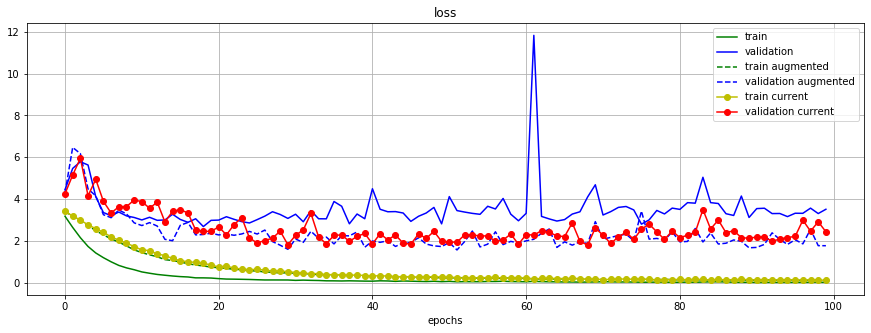

In [28]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

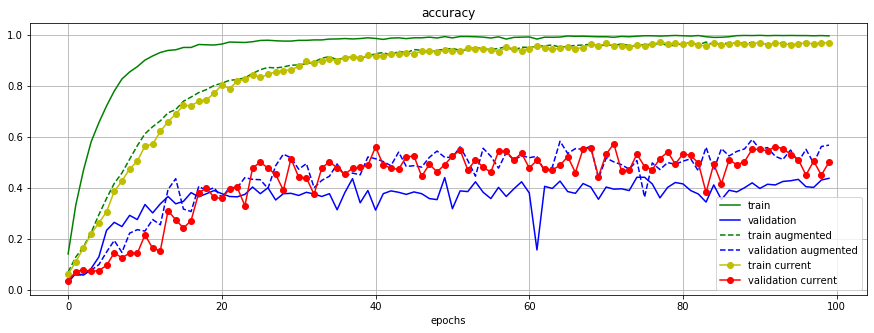

In [29]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

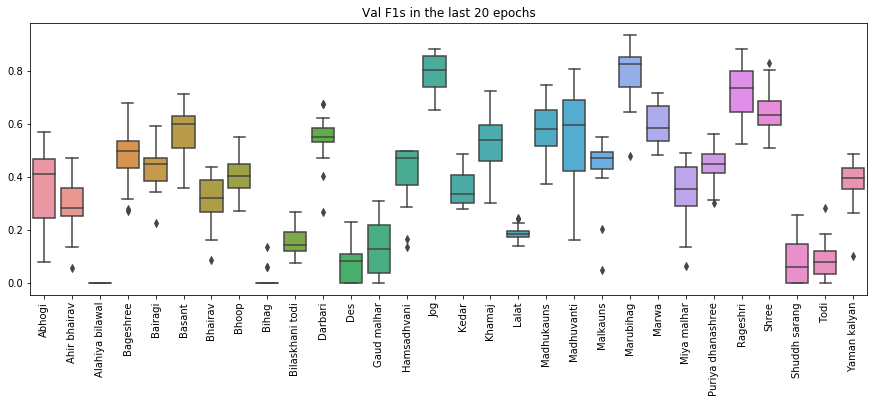

In [30]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

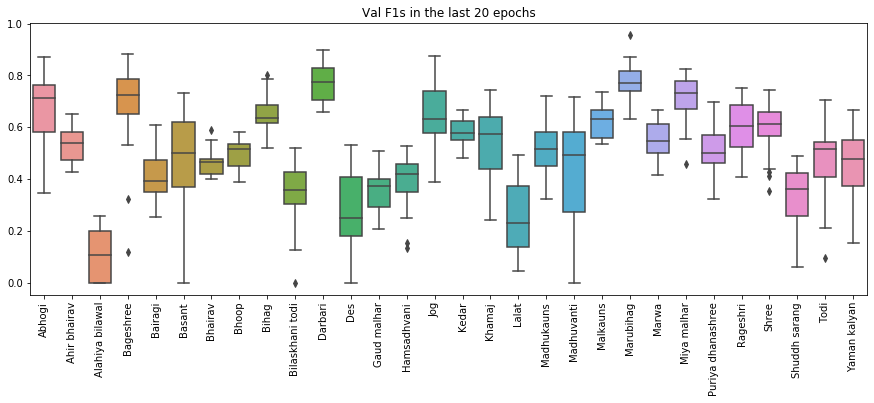

In [31]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

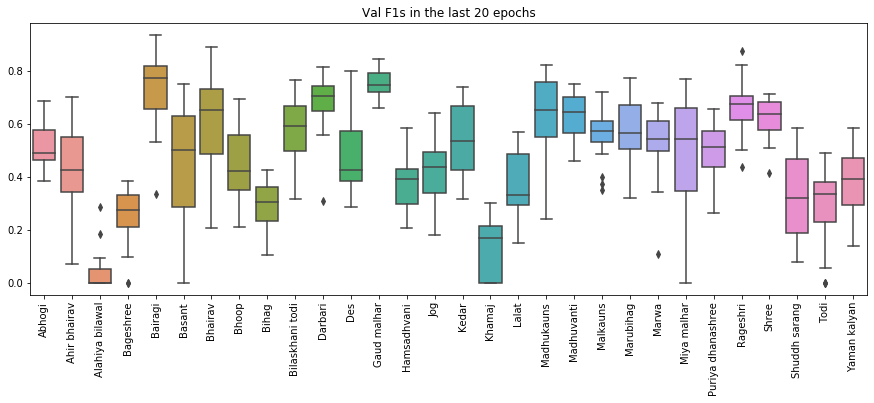

In [32]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

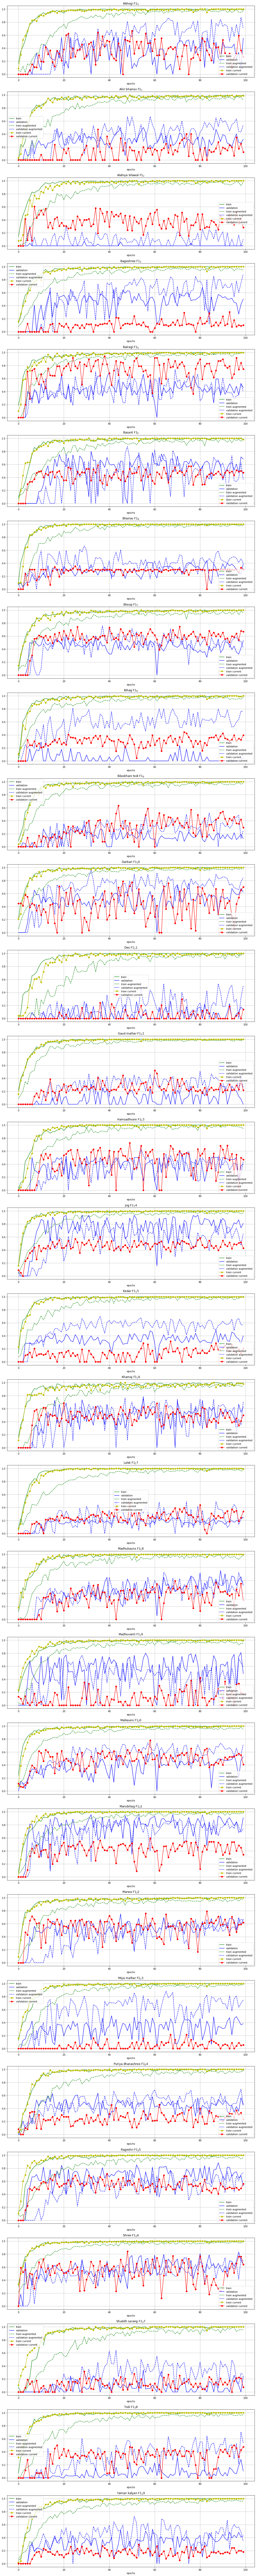

In [38]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(True)
plt.tight_layout()

In [39]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [40]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


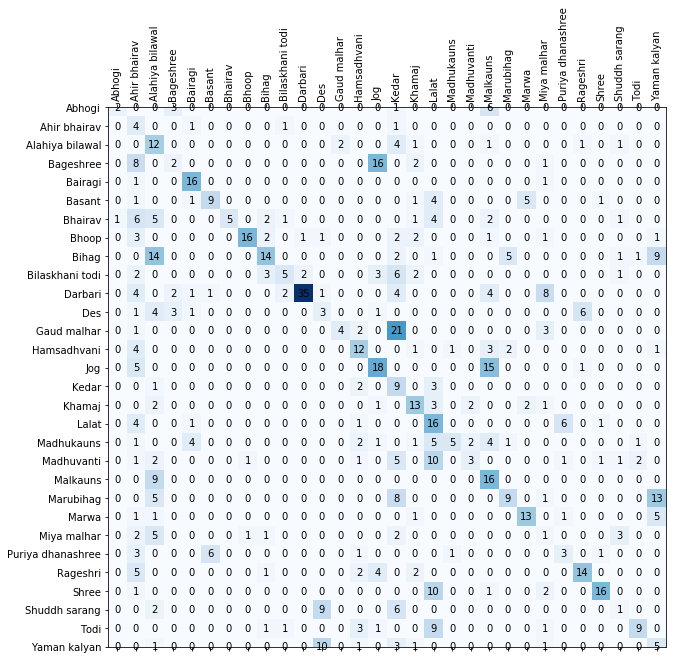

In [41]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [48]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [49]:
precision,recall,f1=process_confusion_matrix(cm)

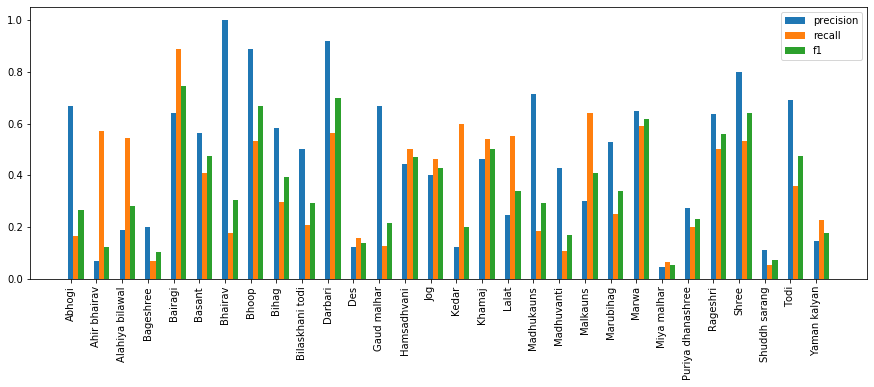

In [50]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()